In [1]:
import numpy as np
import h5py
import pylab

from gwpy.timeseries import TimeSeries
from gwpy.timeseries import TimeSeriesDict

import pycbc.psd
import pycbc.noise
import pycbc.noise.reproduceable
from tqdm.notebook import tqdm

In [2]:

L_psd = pycbc.psd.aLIGOZeroDetHighPower(500, 4096/500, 0.1)

L_noise = pycbc.noise.reproduceable.colored_noise(L_psd,
                                                   start_time=0,
                                                   end_time=3000,
                                                   sample_rate=4096,
                                                   low_frequency_cutoff=0.1,
                                                   seed=0)

p_psd = pycbc.psd.analytical.flat_unity(length=500, delta_f=4096/500, low_freq_cutoff=0)
p_psd = p_psd * 0.1
p_noise = pycbc.noise.reproduceable.colored_noise(p_psd,
                                                   start_time=0,
                                                   end_time=3000,
                                                   sample_rate=L_noise.sample_rate,
                                                   low_frequency_cutoff=0.1,
                                                   seed=2)

len(L_noise): 12288000 len(p_noise): 12288000


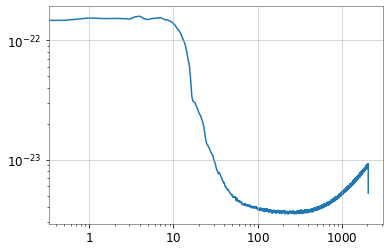

In [3]:
print("len(L_noise):", len(L_noise), "len(p_noise):", len(p_noise))
L_noise_psd = L_noise.psd(2)
pylab.loglog(L_noise_psd.sample_frequencies, L_noise_psd**(1/2))


Create 60Hz sine wave and ±1Hz modulated signal

In [4]:
pi = np.pi
t = L_noise.sample_times
f = 60
amplitude = 1/10

sin1 = amplitude * np.sin(2*pi*f*t)

#input_data is named p_data
p_data = sin1

f2 = 1
sin2 = np.sin(2*pi*f2*t)
modulated_sin = sin1 * (1 + sin2/10)

#target_data is named Lp_data
trans_func = 1e-21
Lp_data = L_noise + trans_func*modulated_sin


In [5]:
#Plot asd

p_data = pycbc.types.timeseries.TimeSeries(p_data, delta_t=L_noise.delta_t, epoch=L_noise.start_time) 
p_asd = p_data.psd(8)**(1/2)

modulated_sin = pycbc.types.timeseries.TimeSeries(modulated_sin, delta_t=L_noise.delta_t, epoch=L_noise.start_time)
modulated_sin_asd = modulated_sin.psd(8)**(1/2)

Lp_asd = (Lp_data.psd(8))**(1/2)

(30, 100)

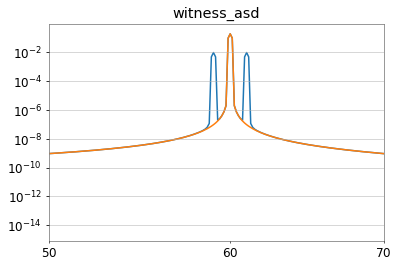

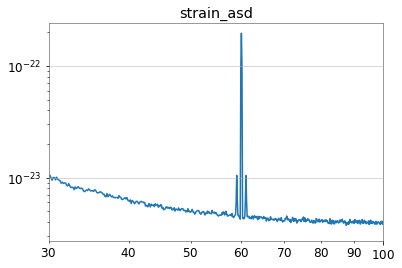

In [6]:
pylab.title("witness_asd")
pylab.loglog(modulated_sin_asd.sample_frequencies, modulated_sin_asd)
pylab.xlim(50, 70)

pylab.loglog(p_asd.sample_frequencies, p_asd)
pylab.xlim(50, 70)

pylab.figure()
pylab.title("strain_asd")
pylab.loglog(Lp_asd.sample_frequencies, Lp_asd)
pylab.xlim(30, 100)

Saving a file

In [7]:
p_data_np = np.array(p_data)
Lp_data_np = np.array(Lp_data)

# Save data as npy files
# np.save("p60_train", p_data_np)
# np.save("Lp60_train", Lp_data_np)

In [8]:
pt = TimeSeries.from_pycbc(p_data, copy=True)
Lpt = TimeSeries.from_pycbc(Lp_data, copy=True)

In [9]:
# Save data as gwf for dc-prod-py36
Lpt.name = 'SIM_STRAIN'
Lpt.channel = 'SIM_STRAIN'
pt.name = 'SIM_WITNESS'
pt.channel = 'SIM_WITNESS'

Lpt.write('./SIM_STRAIN-0-3000.gwf', format='gwf')
# pt.write('./SIM_WITNESS-0-3000.gwf', format='gwf')

In [13]:
# Save data for DeepClean (Online)
data = TimeSeriesDict.fromkeys([Lpt.name, pt.name])
data['SIM_STRAIN'] = Lpt
data['SIM_WITNESS'] = pt
data.write('./SIM_DATA-0-3000.h5', format='hdf5')

with h5py.File('./SIM_DATA-0-3000.h5', 'r+') as f:
    for ch in ['SIM_STRAIN', 'SIM_WITNESS']:
        f[ch].attrs['t0'] = f[ch].attrs['x0']
        f[ch].attrs['sample_rate'] = 1/f[ch].attrs['dx']